# Intro

This notebook provides minimal functionality for applying DMD to noisy climate data. 

The following capabilities are implemented:

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* model monthly across years


In [1]:
%load_ext autoreload
%autoreload 2
import dill

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import sys

sys.path.insert(0, '../src/WeatherDMD/')

from WeatherDMD.plot_jupyter import contour_compare, contour_data
from WeatherDMD.data_wrangle import get_days_before, get_test_set, window_mean
from WeatherDMD.dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd

import xarray
import netCDF4 as nc
from netCDF4 import Dataset

/var/folders/2m/t5bb62r50jbb_r1gf5dsdy680000gr/T/ipykernel_87202/1249405455.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# DATA

In [2]:
dSet = nc.Dataset('../data/2020-02-10_2020-02-20_era5_slice_resampled.nc')  

In [3]:
dSet.variables.keys()

dict_keys(['u_component_of_wind', 'v_component_of_wind', 'geopotential', 'temperature', 'latitude', 'level', 'longitude', 'time'])

In [4]:
dSet.variables['temperature'][:][:, 0, ...]

masked_array(
  data=[[[236.14648, 236.14648, 236.14648, ..., 236.14648, 236.14648,
          236.14648],
         [235.90735, 235.90572, 235.90245, ..., 235.91632, 235.91306,
          235.91061],
         [235.60373, 235.60046, 235.59639, ..., 235.6176 , 235.6127 ,
          235.60863],
         ...,
         [239.98079, 239.96365, 239.94733, ..., 240.03058, 240.01344,
          239.99712],
         [240.72432, 240.71533, 240.70636, ..., 240.75288, 240.74309,
          240.73329],
         [241.49803, 241.49803, 241.49803, ..., 241.49803, 241.49803,
          241.49803]],

        [[236.73575, 236.73575, 236.73575, ..., 236.73575, 236.73575,
          236.73575],
         [236.8753 , 236.8753 , 236.8753 , ..., 236.87613, 236.87613,
          236.87613],
         [236.81654, 236.81573, 236.81573, ..., 236.81818, 236.81818,
          236.81654],
         ...,
         [239.10342, 239.0871 , 239.0724 , ..., 239.14995, 239.13443,
          239.11893],
         [239.88693, 239.87877, 239.

In [5]:
dSet.variables['temperature'][:][:, 0, ...].shape

(44, 361, 720)

In [6]:
data = dSet.variables['temperature'][:][:, 0, ...][:, :360, :360]

In [7]:
DATA = data[None, ...]

In [8]:
DATA.shape

(1, 44, 360, 360)

In [9]:
contour_data(data)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=43), IntSlider(value=180, description='f_…

In [10]:
data.shape

(44, 360, 360)

In [11]:
x = np.linspace(0, 1, data.shape[2])
y = np.linspace(0, 1, data.shape[1])

In [12]:
Integral_pred = np.trapz(np.trapz(data, x, axis = 2), y, axis = 1)


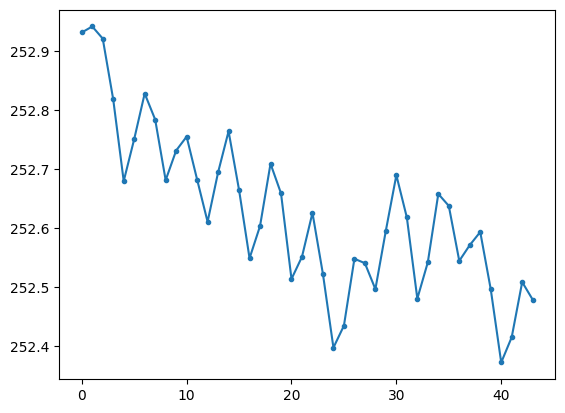

In [13]:
plt.plot(Integral_pred, '.-')

## Train optimised DMD

DMD does not really require batching the data in the deep-AI sense. We simply need to select a training interval and fit DMD. After fitting, DMD model with fitted parameters can be used for prediction on any time interval. 

1. Identify a starting point in time by `year`, `day` 
2. Identify, how many days to train on: `T_train`
3. Select subset of `DATA`, based on the above. Perform window-averaging to de-noise it. 
4. Fit DMD. 
5. Compute DMD predictions from `year`, `day` forward. 

In [14]:
DATA[0].shape

(44, 360, 360)

In [15]:
len(DATA)

1

In [16]:
#
year = 0
day = 20

window = 10
T_train = 11

# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)
X0_ = get_days_before(DATA, year, day, T_train+window-1)
X0 = window_mean(X0_, window = window, t = None)


X0_.shape, X0.shape

((20, 360, 360), (11, 360, 360))

In [17]:
contour_compare(X0_[window-1:], X0)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=10), IntSlider(value=180, description='f_…

In [18]:
X0.shape

(11, 360, 360)

In [20]:
rank = 5
t = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0, t, time_delay = 2, 
                                                     mask = None,
                                                    isKeepFirstTimes = True)
# train dmd
Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, svd_rank= rank)

Psi = reshape_Psi2data(Psi_, data_shape, mask = None)

/Users/lfrance/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/002_Projects/WeatherDMD/WeatherDMD/.venv/lib/python3.12/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [21]:
Psi.shape

(5, 360, 360)

In [22]:
t = np.arange(-T_train, T_train)
true_after = get_test_set(DATA, year, day, window, T_train)
X_true = np.concatenate((X0, true_after), axis = 0)

X_pred = eval_dmd(Lambda, Psi, bn, t)

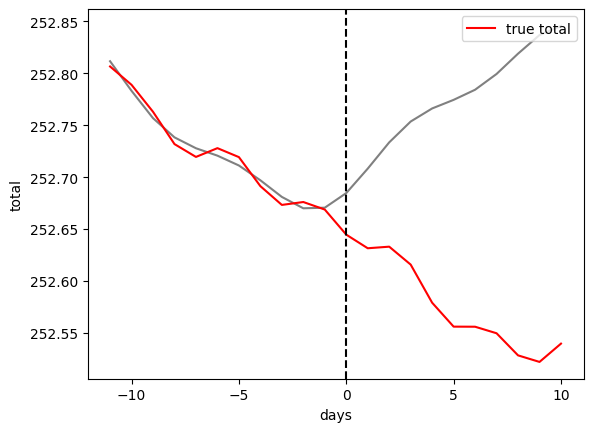

In [23]:
# COMPUTE METRIC OF PREDICTION
Integral_pred = np.trapz(np.trapz(X_pred, x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

# plt.plot(t, Integral_pred1.T, color = 'k');
plt.plot(t, Integral_pred.T, color = 'grey');
plt.plot(t, Integral_true, label = 'true total', color = 'r')
plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total')
plt.xlabel('days')

plt.legend(loc = 'upper right')

In [24]:
contour_compare(X_true, X_pred)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=21), IntSlider(value=180, description='f_…